In [1]:
from rnn import MyGRU, MyLSTM, VanillaRNN, RNN
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%load_ext autoreload
%autoreload 2

In [2]:
# Download the downsampled data frame from csv-file.
raw_data_1 = pd.read_csv(r'data\s_building_data.csv')


In [3]:
raw_data_1

,Time,Floor_network_2_temperature,Radiator_network_1_temperature,Ventilation_network_1_temperature,Outside_temperature_average,District_heat_temperature,Domestic_water_network_1_primary_valve,Domestic_water_network_1_temperature,Inside_temperature,CO2_concentration,Energy_consumption,Outside_humidity,Solar_irradiance
0,2021-11-29 09:00:00+00:00,31.4,50.2,46.2,-7.30,91.0,27.3,58.0,21.829167,490.666667,102.0,88,11.2
1,2021-11-29 10:00:00+00:00,30.4,50.8,45.5,-6.70,90.1,28.3,57.9,21.829167,492.291667,104.0,88,7.3
2,2021-11-29 10:00:00+00:00,30.4,50.8,45.5,-6.70,90.1,28.3,57.9,21.829167,492.291667,112.0,88,7.3
3,2021-11-29 11:00:00+00:00,31.0,50.7,46.7,-7.00,90.4,28.1,58.0,21.891667,514.583333,102.0,89,164.4
4,2021-11-29 11:00:00+00:00,31.0,50.7,46.7,-7.00,90.4,28.1,58.0,21.891667,514.583333,101.0,89,164.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2744,2022-02-14 00:00:00+00:00,27.9,37.0,37.3,1.84,79.5,27.4,58.0,21.262500,442.250000,61.0,94,1.3
2745,2022-02-14 01:00:00+00:00,27.5,37.5,37.4,1.96,79.6,28.2,58.0,21.279167,447.083333,57.0,95,1.3
2746,2022-02-14 02:00:00+00:00,28.0,36.4,37.2,2.14,79.4,29.6,58.0,21.262500,441.416667,61.0,96,0.9
2747,2022-02-14 03:00:00+00:00,27.5,36.7,37.5,2.09,79.1,29.9,58.0,21.254167,440.075000,59.0,96,1.3


In [4]:
# Apply extra preprocessing to the Tampere building(s)
raw_data_1.rename(columns={'timestamp': 'Time',
                        }, inplace=True)

# Drop NAs from the certain columns
todrop = raw_data_1[raw_data_1['Outside_humidity'].isna()].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)
todrop = raw_data_1[raw_data_1['Solar_irradiance'].isna()].index.values
raw_data_1 = raw_data_1.drop(todrop, axis = 0)


raw_data_1 = raw_data_1[["Time", "District_heat_temperature", "Domestic_water_network_1_temperature", "Energy_consumption", 
                         "Radiator_network_1_temperature", "Ventilation_network_1_temperature",
                         "Outside_temperature_average", "Outside_humidity", "Solar_irradiance"]]


hvac_model_1 = MyGRU(quant=['Energy_consumption'], seq=12, fut=0, parameters=['District_heat_temperature',
       'Domestic_water_network_1_temperature',
       'Radiator_network_1_temperature',
       'Ventilation_network_1_temperature', 'Outside_temperature_average',
       'Outside_humidity', 'Solar_irradiance'])

x_train_1, y_train_1, x_test_1, y_test_1 = hvac_model_1.preprocess(raw_data_1, 0.2)

Shape of training data: (2187, 12, 7)
Shape of testing data: (538, 12, 7)


In [5]:
# # Train the model using custom fit method. 
# # Does hyperparameter optimization automatically in pre-defined search space. Comment row below, if you have already trained the model.
# hvac_model_1.fit(X=x_train_1, y=y_train_1, epochs=500, max_trials=15)
# hvac_model_1.save()

In [6]:
# Uncomment below to load the existing model, scaler and other variables, if you have the model trained already.
hvac_model_1.load(r'model\GRU_Energy_consumption_s')

Model loaded.
Scaler loaded.
Other variables loaded.


In [7]:
# # Calculating prediction intervals using bootstrap
# rounds = 12     # Number of data instances to calculate prediction intervals to.

# for i in range(rounds):
    
#     # Calculating prediction percentiles and saving them to a csv file.
#     hvac_model_1.prediction_interval(x_train, y_train, x_test[i])     # NB! The process is computationally intensive.

In [8]:
# # Load the existing intervals if they have been predicted
# low, up = hvac_model_1.load_intervals(r'F:\hamk\smart_city\roman\HAMK_Smart_City\GRU_Energy_consumption_2022-04-05/pred_ints.csv')

In [9]:
# Use the existing confidence interval multipliers (assuming Gaussian distribution) for the prediction of the intervals
probability_multipliers = {"50": 0.67, "55": 0.76, "60": 0.84, "65": 0.93, "70": 1.04, "75": 1.15, "80": 1.28,
                           "85": 1.44, "90": 1.64, "95": 1.96, "96": 2.05, "97": 2.17, "98": 2.33, "99": 2.58}

def predict_intervals(probability, measurements, predictions):
    '''
    Function for prediction of the confidence intervals using the residual standard deviation method.
    Inputs: desired confidence interval value as string, array of the predictions, array of the measurements
    Outputs: array of lower-bound confidence, array of upper-bound confidence
    '''
    assert probability in probability_multipliers, "Please select the probability from the dictionary"
    low = []
    up = []
    sq_residuals = []
    for  measurement,prediction in zip(measurements, predictions):
        sq_residuals.append(((measurement - prediction)**2)[0])
    sq_residuals = np.array(sq_residuals)
    res_stdev = np.sqrt(np.sum(sq_residuals) / (len(sq_residuals)-1))
    multiplier = probability_multipliers[probability]
    for measurement in measurements:
        low.append((measurement - multiplier * res_stdev)[0])
        up.append((measurement + multiplier * res_stdev)[0])
    low = np.array(low)
    up = np.array(up)
    low = low.flatten()
    up = up.flatten()
    return low, up

In [10]:

train_preds_1 = hvac_model_1.model.predict(x_train_1)
test_preds_1 = hvac_model_1.model.predict(x_test_1)

# Loading prediction intervals from disk.
#low, up = hvac_model.load_intervals(r'C:\Users\romat\Documents\GitHub\HAMK_Smart_City\GRU_Inside_temperature_2022-01-10\pred_ints.csv')


inv_preds_train_1, inv_y_train_1 = hvac_model_1.inv_target(x_train_1, train_preds_1, y_train_1)
inv_preds_test_1, inv_y_test_1 = hvac_model_1.inv_target(x_test_1, test_preds_1, y_test_1)

In [11]:
print("Train RMSE: " + str(np.sqrt(mean_squared_error(inv_preds_train_1, inv_y_train_1))))
print("Test RMSE: " + str(np.sqrt(mean_squared_error(inv_preds_test_1, inv_y_test_1))))
print("Train MAE: " + str(mean_absolute_error(inv_preds_train_1, inv_y_train_1)))
print("Test MAE: " + str(mean_absolute_error(inv_preds_test_1, inv_y_test_1)))
print("Train MAPE: " + str(mean_absolute_percentage_error(inv_preds_train_1, inv_y_train_1)))
print("Test MAPE: " + str(mean_absolute_percentage_error(inv_preds_test_1, inv_y_test_1)))

Train RMSE: 4.683541793038722
Test RMSE: 3.932904197675374
Train MAE: 3.5718278560299397
Test MAE: 2.743371486448233
Train MAPE: 0.036929730206300686
Test MAPE: 0.03672521679420286


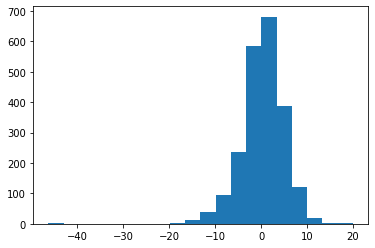

In [12]:
# Assess the distribution of the residuals
plt.hist(inv_preds_train_1 - inv_y_train_1, bins = 20)
plt.show()

# Predict the intervals
#low, up = hvac_model.inv_target(x_test, low, up)
low, up = predict_intervals("85", inv_y_train_1, inv_preds_train_1)

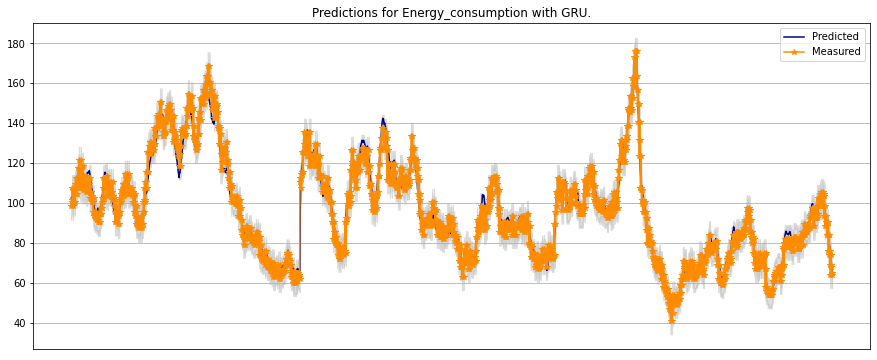

Train MAPE: 0.036929730206300686


In [13]:
low, up = predict_intervals("85", inv_y_train_1, inv_preds_train_1)
# Plot model prediction alongside measured values.
hvac_model_1.plot_preds(inv_preds_train_1, inv_y_train_1, low, up)
print("Train MAPE: " + str(mean_absolute_percentage_error(inv_preds_train_1, inv_y_train_1)))

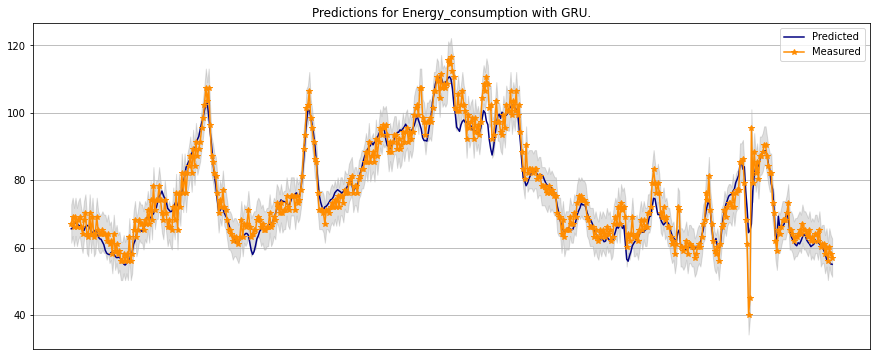

Test MAPE: 0.03672521679420286


In [14]:
low, up = predict_intervals("85", inv_y_test_1, inv_preds_test_1)
# Plot model prediction alongside measured values.
hvac_model_1.plot_preds(inv_preds_test_1, inv_y_test_1, low, up)
print("Test MAPE: " + str(mean_absolute_percentage_error(inv_preds_test_1, inv_y_test_1)))